#NLP Exp 9 <hr>
Name: Sachi Shah <br>
Roll no.: C094 <br>
Program: BTech Integrated Computers <br>
Division: C <br>
Date of Experiment: 27/03/2023 <br>
Date of Submission: 30/03/2023 <br>
<br>
Aim: Stock Price Prediction RNN 

#B1: Tasks to be performed

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = yf.download('ESCORTS.NS',period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-27,815.900024,829.000000,809.400024,824.900024,811.780884,1012400
2018-03-28,823.000000,823.400024,814.950012,818.099976,805.089050,634190
2018-04-02,828.700012,886.150024,826.099976,882.500000,868.464722,2993082


In [ ]:
data_target = data.iloc[:1182,4]
data_test = data.iloc[1132:,4]
data = data.loc[:,["Adj Close"]].values

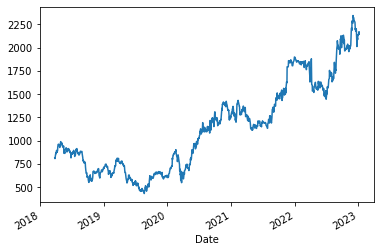

In [ ]:
plot = data_target.plot()

In [ ]:
#Check Length 
print("Length of Data:{}".format(len(data)))
print("Length of Data_Target:{}".format(len(data_target)))

Length of Data:1237
Length of Data_Target:1182


In [ ]:
#Scaling Dataset
def scaledata(data_target):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0,1))
    data_target_scaled = scaler.fit_transform(np.array(data_target).reshape(-1,1))
    #plot_scaled = pd.DataFrame(data_target_scaled).plot()
    print(data_target.shape)
    return data_target_scaled, scaler

In [ ]:
data_target_scaled = scaledata(data_target)[0]
scaler = scaledata(data_target)[1]
data_target_scaled

(1182,)
(1182,)


array([[0.19973502],
       [0.19624585],
       [0.22929035],
       ...,
       [0.90625105],
       [0.89504081],
       [0.90711132]])

In [ ]:
data_test_scaled = scaledata(data_test)[0]

(105,)


In [ ]:
#Create pattern and end price set
def createPatternSet(data_target_scaled,steps=7):   
    x_patern = []
    y_price = []

    for day in range(steps,data_target_scaled.shape[0]):
        row = data_target_scaled[day-steps:day,0]
        #print(len(row))
        x_patern.append(row)
        y = data_target_scaled[day,0]
        #print(y)
        y_price.append(y)
    
    x_patern,y_price = np.array(x_patern),np.array(y_price)
    x_patern = x_patern.reshape(x_patern.shape[0],x_patern.shape[1],1)
    
    return x_patern,y_price

In [ ]:
train_pattern = createPatternSet(data_target_scaled,steps=50)

In [ ]:
x_train = train_pattern[0]
y_train = train_pattern[1]

In [ ]:
x_train.shape

(1132, 50, 1)

In [ ]:
y_train.shape

(1132,)

In [ ]:
x_train

array([[[0.19973502],
        [0.19624585],
        [0.22929035],
        ...,
        [0.2336775 ],
        [0.2375772 ],
        [0.2460436 ]],

       [[0.19624585],
        [0.22929035],
        [0.23075277],
        ...,
        [0.2375772 ],
        [0.2460436 ],
        [0.24848085]],

       [[0.22929035],
        [0.23075277],
        [0.22421058],
        ...,
        [0.2460436 ],
        [0.24848085],
        [0.24758293]],

       ...,

       [[0.813206  ],
        [0.81075541],
        [0.81972358],
        ...,
        [0.89277264],
        [0.89235549],
        [0.89259023]],

       [[0.81075541],
        [0.81972358],
        [0.82929138],
        ...,
        [0.89235549],
        [0.89259023],
        [0.90625105]],

       [[0.81972358],
        [0.82929138],
        [0.81729903],
        ...,
        [0.89259023],
        [0.90625105],
        [0.89504081]]])

In [ ]:
class StocksPriceRNN():

    loss='mean_squared_error'
    batch_size=32
    neurons = 50
    model = tf.keras.Sequential()
    def __init__(self,x_train,y_train,epoch):
        self.x_train = x_train
        self.y_train = y_train
        self.epoch = epoch
    
    def buildArchitecture(self,rnn=2,dense=1):
        StocksPriceRNN.model = tf.keras.Sequential()
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                            activation='tanh',
                                            return_sequences = True,
                                            input_shape = (self.x_train.shape[1],1)))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        for i in range(rnn):
            StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = True))
            StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        #return sequense changed to false
        StocksPriceRNN.model.add(tf.keras.layers.SimpleRNN(StocksPriceRNN.neurons,
                                                activation='tanh',
                                                return_sequences = False))
        StocksPriceRNN.model.add(tf.keras.layers.Dropout(0.2))
        
        for i in range(dense):
            StocksPriceRNN.model.add(tf.keras.layers.Dense(units=StocksPriceRNN.neurons,
                                            activation='tanh'))
        
        #Output
        StocksPriceRNN.model.add(tf.keras.layers.Dense(units=1))
        return StocksPriceRNN.model.summary()
    
    def compiler(self):
        opt= tf.keras.optimizers.Adam()
        StocksPriceRNN.model.compile(optimizer = opt,
                                    loss = StocksPriceRNN.loss)
        return StocksPriceRNN.model.summary()
        
    def modelfit(self):
        history = StocksPriceRNN.model.fit(self.x_train,self.y_train,
                                        epochs=self.epoch,batch_size=StocksPriceRNN.batch_size,validation_split=0.2,
                                       )
        return history
    
    def changeBatchSize(self,size):
        StocksPriceRNN.batch_size = size
        print("Changed!")
    def changeNeurons(self,size):
        StocksPriceRNN.neurons = size
        print("Changed!")
    def changeEpoch(self,size):
        self.epoch = size
        print("Changed!")

In [ ]:
RNN1 = StocksPriceRNN(x_train,y_train,50)

In [ ]:
RNN1.buildArchitecture(2,0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [ ]:
RNN1.compiler()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)               

In [ ]:
history = RNN1.modelfit()

Epoch 1/50
29/29 [==============================] - 11s 94ms/step - loss: 0.5074 - val_loss: 0.0817
Epoch 2/50
29/29 [==============================] - 2s 73ms/step - loss: 0.2919 - val_loss: 0.0103
Epoch 3/50
29/29 [==============================] - 2s 86ms/step - loss: 0.2169 - val_loss: 0.0090
Epoch 4/50
29/29 [==============================] - 2s 64ms/step - loss: 0.1912 - val_loss: 0.0083
Epoch 5/50
29/29 [==============================] - 2s 59ms/step - loss: 0.1686 - val_loss: 0.0142
Epoch 6/50
29/29 [==============================] - 2s 59ms/step - loss: 0.1142 - val_loss: 0.0268
Epoch 7/50
29/29 [==============================] - 2s 58ms/step - loss: 0.1129 - val_loss: 0.0453
Epoch 8/50
29/29 [==============================] - 2s 55ms/step - loss: 0.0986 - val_loss: 0.0097
Epoch 9/50
29/29 [==============================] - 2s 59ms/step - loss: 0.0804 - val_loss: 0.0161
Epoch 10/50
29/29 [==============================] - 3s 96ms/step - loss: 0.0667 - val_loss: 0.0046
Epoch 11

In [ ]:
#Prepare Test Data
test = data[len(data) - len(data_test) - 50:]
test = scaler.transform(test)

In [ ]:
test_pattern = createPatternSet(test,steps=50)
x_test = test_pattern[0]
y_test = test_pattern[1]

In [ ]:
#Predict the value for test set
y_test

array([0.82929138, 0.81729903, 0.83927633, 0.82371235, 0.82287811,
       0.82611081, 0.81432703, 0.79714671, 0.81276281, 0.82994314,
       0.81109434, 0.81417059, 0.82598046, 0.82788361, 0.82731007,
       0.83536578, 0.9215022 , 0.92997506, 0.93065291, 0.91594914,
       0.96962806, 0.95940844, 0.9560193 , 0.96866341, 1.        ,
       0.9881119 , 0.98743405, 0.97465958, 0.96902837, 0.97020153,
       0.96848086, 0.96238043, 0.93237345, 0.92087654, 0.92765482,
       0.91143903, 0.92502169, 0.91785235, 0.89743921, 0.86409527,
       0.82553728, 0.87256813, 0.86453852, 0.8777822 , 0.89277264,
       0.89235549, 0.89259023, 0.90625105, 0.89504081, 0.90711132,
       0.90526031, 0.92843693, 0.91169973, 0.88802792, 0.87640052,
       0.88078029, 0.86920509, 0.87394994, 0.86678059, 0.87225537,
       0.86876184, 0.87228133, 0.8708215 , 0.86558133, 0.82459872,
       0.83304555, 0.8653727 , 0.82775325, 0.8459503 , 0.85950687,
       0.85155542, 0.82204388, 0.81015578, 0.80374245, 0.84941

In [ ]:
x_test

array([[[0.65316024],
        [0.73718494],
        [0.72495792],
        ...,
        [0.813206  ],
        [0.81075541],
        [0.81972358]],

       [[0.73718494],
        [0.72495792],
        [0.71692824],
        ...,
        [0.81075541],
        [0.81972358],
        [0.82929138]],

       [[0.72495792],
        [0.71692824],
        [0.70178141],
        ...,
        [0.81972358],
        [0.82929138],
        [0.81729903]],

       ...,

       [[0.91169973],
        [0.88802792],
        [0.87640052],
        ...,
        [0.77193664],
        [0.76633152],
        [0.76077859]],

       [[0.88802792],
        [0.87640052],
        [0.88078029],
        ...,
        [0.76633152],
        [0.76077859],
        [0.74453676]],

       [[0.87640052],
        [0.88078029],
        [0.86920509],
        ...,
        [0.76077859],
        [0.74453676],
        [0.73160585]]])

In [ ]:
pred = RNN1.model.predict(x=x_test)
pred.shape

4/4 [==============================] - 1s 12ms/step


(105, 1)

In [ ]:
#Transform back the inverse value

output = scaler.inverse_transform(pred)
org_vals = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
output

array([[1985.1119],
       [1987.4044],
       [1983.5674],
       [1995.1555],
       [2000.3013],
       [2008.3126],
       [2008.9501],
       [1994.2983],
       [1983.0316],
       [1968.9231],
       [1969.6605],
       [1982.2107],
       [1987.7784],
       [1992.0302],
       [1990.6432],
       [1987.3688],
       [1997.8147],
       [2024.7683],
       [2067.65  ],
       [2108.085 ],
       [2127.3088],
       [2146.4443],
       [2158.6646],
       [2170.2317],
       [2177.6519],
       [2189.3813],
       [2213.2422],
       [2226.0857],
       [2224.333 ],
       [2206.7617],
       [2193.2268],
       [2188.0317],
       [2192.322 ],
       [2188.0215],
       [2175.526 ],
       [2154.0735],
       [2137.2715],
       [2127.0535],
       [2118.5308],
       [2121.264 ],
       [2111.307 ],
       [2083.1448],
       [2062.31  ],
       [2044.1825],
       [2044.4673],
       [2050.4385],
       [2071.5024],
       [2092.377 ],
       [2098.3054],
       [2094.233 ],


In [ ]:
def plotting(org_vals,output):
    plt.figure(figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(org_vals,color="Green",label="Org value")
    plt.plot(output,color="Yellow",label="Predicted")
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

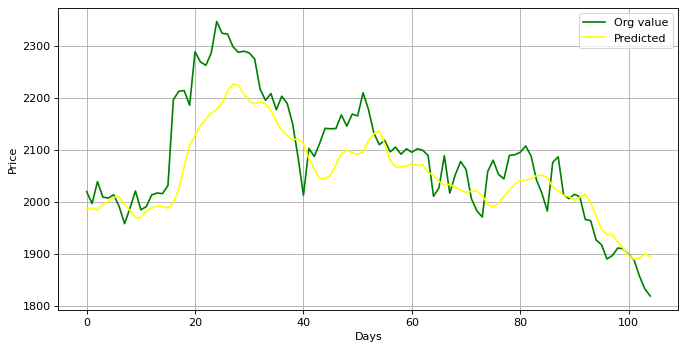

In [ ]:
plotting(org_vals,output)

#B.2: Observations and Learning: <br>
Understood the LSTM architecture and it’s use cases and how to preprocess the data to make sure it’s always in 3Dim format. Moreover, scaled the data before feeding to the model using “Close” label as the target feature.

#B.3 Conclusion:<br>
Successfully implemented LSTM Model for Stock Price Prediction for the Company Apple. Revisted concepts of RNN and used a Kaggle Dataset for completing the task in Keras and Tensorflow.

#B.4 Question of curiosity:<br>

1.	<b>What is dimensionality reduction problem?</b><br>
Ans: Dimensionality reduction is the process of reducing the number of input features or variables in a dataset while preserving the important information contained in the data. It is an important technique in machine learning and data analysis, as it can help improve the performance and efficiency of models by reducing the complexity of the data.
The dimensionality reduction problem arises when working with datasets that contain a large number of input features or variables. These high-dimensional datasets can be difficult to work with, as they can lead to overfitting, increase the computational complexity of models, and make it harder to visualize and understand the data.<br>
Dimensionality reduction methods aim to overcome these challenges by identifying the most important features or patterns in the data, and projecting the data onto a lower-dimensional space while preserving as much of the original information as possible. This can be done using techniques such as Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), Linear Discriminant Analysis (LDA), and many others.

2.	<b>What are the disadvantages of RNN?</b><br>
Ans: Recurrent Neural Networks (RNNs) have become a popular and powerful tool in the field of deep learning, especially for processing sequential data. However, like any other machine learning technique, RNNs have their own set of limitations and drawbacks. Some of the main disadvantages of RNNs include:
-	Vanishing and exploding gradients: RNNs can suffer from the problem of vanishing and exploding gradients, which can make it difficult to train the network effectively. 
-	Lack of long-term memory: RNNs have a limited ability to capture long-term dependencies in the input data. This means that they may struggle to remember information from earlier time steps in the sequence, which can limit their performance on tasks that require long-term memory.
-	Computationally expensive: RNNs can be computationally expensive to train and run, especially for large datasets or complex models.
-	Difficulty in parallelization: RNNs are inherently sequential models, which means that they are difficult to parallelize across multiple CPUs or GPUs. 
-	Difficulty in handling variable-length sequences: RNNs require fixed-length sequences as inputs, which can make it difficult to handle variable-length sequences

